# 03. 迷路環境の実装と検証

このノートブックでは、カスタム迷路環境を実装し、報酬設計を検証します。

## 迷路環境の仕様

- **グリッドサイズ**: 10×10
- **観測**: 部分観測（エージェント周囲5×5）
- **行動空間**: Discrete(4) - 上下左右
- **観測空間**: Box(shape=(25,)) - 25次元ベクトル
- **最大ステップ**: 200

## 報酬設計

- **ゴール到達**: +1.0
- **毎ステップ**: -0.01（最短経路を促す）
- **壁衝突**: -0.05（無効行動の抑制）

## 要件
- 要件 1.4: 迷路Gym環境の実装、報酬設計の検証（ゴール+1.0、ステップ-0.01、壁衝突-0.05）

In [1]:
# 必要なライブラリのインポート
import sys
sys.path.append('..')

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from ml.envs.maze_env import MazeEnv
import warnings
import japanize_matplotlib
warnings.filterwarnings('ignore')

print("✅ ライブラリのインポート完了")

✅ ライブラリのインポート完了


## 1. 迷路環境の作成と確認

まず、デフォルトの迷路環境を作成し、基本的な情報を確認します。

In [2]:
# 迷路環境の作成
env = MazeEnv(render_mode='human')

print("=== 迷路環境の仕様 ===")
print(f"観測空間: {env.observation_space}")
print(f"行動空間: {env.action_space}")
print(f"グリッドサイズ: {env.grid_size}×{env.grid_size}")
print(f"部分観測サイズ: {env.observation_size}×{env.observation_size}")
print(f"最大ステップ: {env.max_steps}")
print(f"\nスタート位置: {env.start_pos}")
print(f"ゴール位置: {env.goal_pos}")
print("\n行動:")
print("  0: 上")
print("  1: 下")
print("  2: 左")
print("  3: 右")
print("\n観測値の意味:")
print("  0.0: 通路")
print("  1.0: 壁")
print("  2.0: ゴール")

=== 迷路環境の仕様 ===
観測空間: Box(0.0, 2.0, (25,), float32)
行動空間: Discrete(4)
グリッドサイズ: 10×10
部分観測サイズ: 5×5
最大ステップ: 200

スタート位置: (1, 1)
ゴール位置: (8, 8)

行動:
  0: 上
  1: 下
  2: 左
  3: 右

観測値の意味:
  0.0: 通路
  1.0: 壁
  2.0: ゴール


## 2. 迷路レイアウトの可視化

迷路の全体像を可視化します。

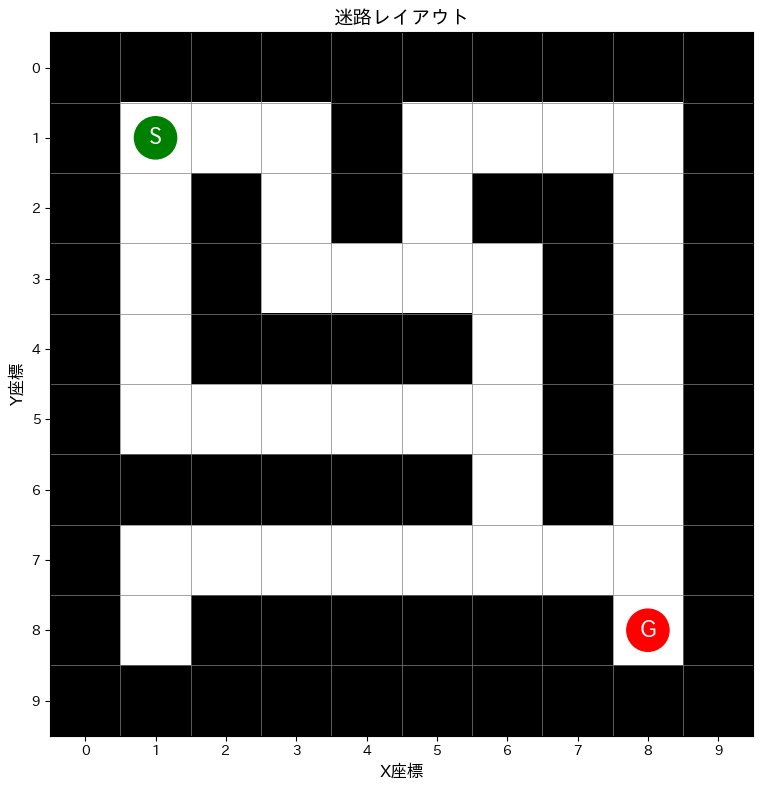


凡例:
  白: 通路
  黒: 壁
  緑(S): スタート位置
  赤(G): ゴール位置


In [3]:
def visualize_maze(env, title="迷路レイアウト"):
    """
    迷路を可視化
    
    Args:
        env: MazeEnv環境
        title: グラフのタイトル
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 迷路を描画
    maze_display = np.copy(env.maze).astype(float)
    
    # カラーマップ: 0=白(通路), 1=黒(壁)
    ax.imshow(maze_display, cmap='gray_r', vmin=0, vmax=1)
    
    # スタート位置をマーク（緑）
    start_y, start_x = env.start_pos
    circle = patches.Circle((start_x, start_y), 0.3, color='green', zorder=10)
    ax.add_patch(circle)
    ax.text(start_x, start_y, 'S', ha='center', va='center', 
            fontsize=16, fontweight='bold', color='white', zorder=11)
    
    # ゴール位置をマーク（赤）
    goal_y, goal_x = env.goal_pos
    circle = patches.Circle((goal_x, goal_y), 0.3, color='red', zorder=10)
    ax.add_patch(circle)
    ax.text(goal_x, goal_y, 'G', ha='center', va='center', 
            fontsize=16, fontweight='bold', color='white', zorder=11)
    
    # グリッド線
    ax.set_xticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    
    # 軸ラベル
    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_xlabel('X座標', fontsize=12)
    ax.set_ylabel('Y座標', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 迷路を可視化
visualize_maze(env)
print("\n凡例:")
print("  白: 通路")
print("  黒: 壁")
print("  緑(S): スタート位置")
print("  赤(G): ゴール位置")

## 3. 部分観測の確認

エージェントが実際に見ている5×5の部分観測を確認します。

観測ベクトルの形状: (25,)
観測ベクトルの最小値: 0.0
観測ベクトルの最大値: 1.0

初期観測（最初の10要素）: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


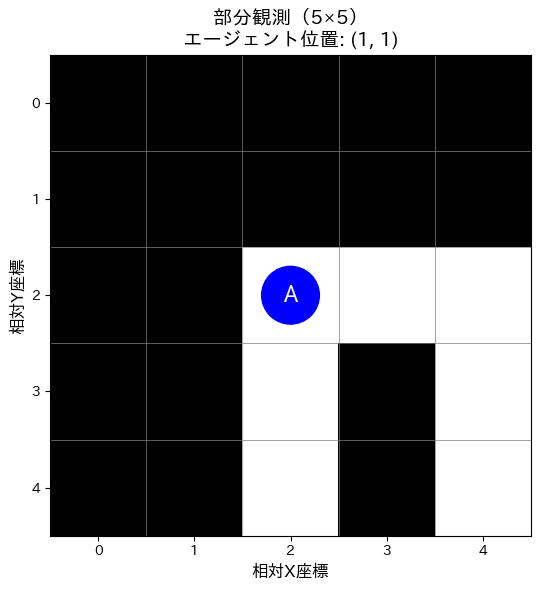


凡例:
  白: 通路
  黒: 壁
  赤: ゴール
  青(A): エージェント（常に中央）


In [4]:
def visualize_partial_observation(env, obs, agent_pos, title="部分観測（5×5）"):
    """
    部分観測を可視化
    
    Args:
        env: MazeEnv環境
        obs: 観測ベクトル（25次元）
        agent_pos: エージェント位置
        title: グラフのタイトル
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # 観測を5×5に変形
    obs_2d = obs.reshape(env.observation_size, env.observation_size)
    
    # カラーマップ: 0=白(通路), 1=黒(壁), 2=赤(ゴール)
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'red'])
    ax.imshow(obs_2d, cmap=cmap, vmin=0, vmax=2)
    
    # エージェント位置をマーク（中央）
    center = env.observation_size // 2
    circle = patches.Circle((center, center), 0.3, color='blue', zorder=10)
    ax.add_patch(circle)
    ax.text(center, center, 'A', ha='center', va='center', 
            fontsize=16, fontweight='bold', color='white', zorder=11)
    
    # グリッド線
    ax.set_xticks(np.arange(-0.5, env.observation_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.observation_size, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    
    # 軸ラベル
    ax.set_xticks(range(env.observation_size))
    ax.set_yticks(range(env.observation_size))
    ax.set_xlabel('相対X座標', fontsize=12)
    ax.set_ylabel('相対Y座標', fontsize=12)
    ax.set_title(f"{title}\nエージェント位置: {agent_pos}", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 環境をリセットして初期観測を取得
obs, info = env.reset()
print(f"観測ベクトルの形状: {obs.shape}")
print(f"観測ベクトルの最小値: {obs.min()}")
print(f"観測ベクトルの最大値: {obs.max()}")
print(f"\n初期観測（最初の10要素）: {obs[:10]}")

# 部分観測を可視化
visualize_partial_observation(env, obs, env.agent_pos)
print("\n凡例:")
print("  白: 通路")
print("  黒: 壁")
print("  赤: ゴール")
print("  青(A): エージェント（常に中央）")